In [12]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import pathlib
import random
import string
import re
import numpy as np

import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

import keras
from keras import layers
from keras import ops
from keras.layers import TextVectorization


In [13]:
with open("spa.txt") as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, spa = line.split("\t")
    spa = "[start] " + spa + " [end]"
    text_pairs.append((eng, spa))

In [14]:
for _ in range(5):
    print(random.choice(text_pairs))

('I will be busy this afternoon.', '[start] Voy a estar ocupada esta tarde. [end]')
('Tom kicked the stool out from under Mary.', '[start] Tom sacó el taburete situado bajo Mary. [end]')
('They got married last fall.', '[start] Ellos se casaron el otoño pasado. [end]')
('I quit.', '[start] Renuncié. [end]')
('Can I leave my bag here?', '[start] ¿Puedo dejar aquí mi bolsa? [end]')


In [15]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

118964 total pairs
83276 training pairs
17844 validation pairs
17844 test pairs


In [16]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf_strings.lower(input_string)
    return tf_strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)

In [17]:
def format_dataset(eng, spa):
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": spa[:, :-1],
        },
        spa[:, 1:],
    )


def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf_data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [18]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


2025-02-19 03:30:27.541270: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
import keras.ops as ops


class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None

        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        inputs, encoder_outputs = inputs
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is None:
            inputs_padding_mask, encoder_outputs_padding_mask = None, None
        else:
            inputs_padding_mask, encoder_outputs_padding_mask = mask

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask,
            query_mask=inputs_padding_mask,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            query_mask=inputs_padding_mask,
            key_mask=encoder_outputs_padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = ops.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = ops.arange(sequence_length)[:, None]
        j = ops.arange(sequence_length)
        mask = ops.cast(i >= j, dtype="int32")
        mask = ops.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = ops.concatenate(
            [ops.expand_dims(batch_size, -1), ops.convert_to_tensor([1, 1])],
            axis=0,
        )
        return ops.tile(mask, mult)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

In [20]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)([x, encoder_outputs])
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

transformer = keras.Model(
    {"encoder_inputs": encoder_inputs, "decoder_inputs": decoder_inputs},
    decoder_outputs,
    name="transformer",
)

In [21]:
epochs = 30  # This should be at least 30 for convergence

transformer.summary()
transformer.compile(
    "rmsprop",
    loss=keras.losses.SparseCategoricalCrossentropy(ignore_class=0),
    metrics=["accuracy"],
)
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)


Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 256) │  3,845,120 │ encoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, None)      │          0 │ encoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 256) │  3,845,120 │ decoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │  3,155,456 │ positional_embed… │
│ (TransformerEncode… │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, None)      │          0 │ decoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 256) │  5,259,520 │ positional_embed… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
│                     │                   │            │ not_equal_3[0][0… │
│                     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, None, 256) │          0 │ transformer_deco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, None,      │  3,855,000 │ dropout_7[0][0]   │
│                     │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,960,216 (76.14 MB)

 Trainable params: 19,960,216 (76.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 3651s 3s/step - accuracy: 0.1039 - loss: 5.0816 - val_accuracy: 0.1923 - val_loss: 2.8835
Epoch 2/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 1570s 1s/step - accuracy: 0.1934 - loss: 2.9256 - val_accuracy: 0.2139 - val_loss: 2.4467
Epoch 3/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 3760s 3s/step - accuracy: 0.2148 - loss: 2.4805 - val_accuracy: 0.2211 - val_loss: 2.3595
Epoch 4/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 1785s 1s/step - accuracy: 0.2247 - loss: 2.2845 - val_accuracy: 0.2267 - val_loss: 2.2260
Epoch 5/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 830s 638ms/step - accuracy: 0.2322 - loss: 2.1607 - val_accuracy: 0.2276 - val_loss: 2.2172
Epoch 6/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 883s 678ms/step - accuracy: 0.2367 - loss: 2.0940 - val_accuracy: 0.2312 - val_loss: 2.1930
Epoch 7/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 897s 689ms/step - accuracy: 0.2413 - loss: 2.0305 - val_accuracy: 0.2293 - val_loss: 2.2400
Epoch 8/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 916s 704ms/step - accuracy: 

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kaushalchamarthy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


ENG: He can't speak English, can he?
OUT: [start] Él no sabe hablar inglés [end]
REF: [start] ¿Él no puede hablar inglés, no es así? [end]
BLEU: 0.4639 | Adjusted Score: 0.6774
------------------------------------------------------------
ENG: It's one of those moments.
OUT: [start] es uno de esos últimos [end]
REF: [start] Es uno de esos momentos. [end]
BLEU: 1.0000 | Adjusted Score: 1.0000
------------------------------------------------------------
ENG: Does Tom still live in Boston?
OUT: [start] tom todavía vive en boston [end]
REF: [start] ¿Tom todavía vive en Boston? [end]
BLEU: 1.0000 | Adjusted Score: 1.0000
------------------------------------------------------------
ENG: During warm weather, sweating helps man regulate his body temperature.
OUT: [start] cuando clima caliente le [UNK] el hombre se [UNK] bien su temperatura [end]
REF: [start] Durante tiempo calurosos, sudar ayuda al hombre a regular su temperatura corporal. [end]
BLEU: 0.3587 | Adjusted Score: 0.5532
-----------

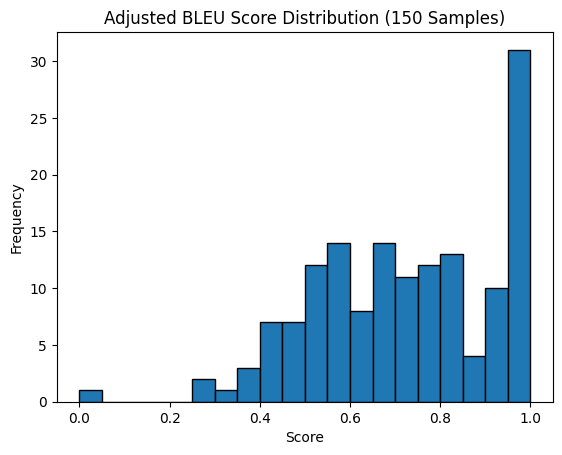

In [31]:
import random
import nltk
import re
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt
from Levenshtein import ratio  # Requires `pip install python-Levenshtein`

nltk.download('punkt')

# Use stronger smoothing
smoothie = SmoothingFunction().method7  

# BLEU weights: Favor unigrams (BLEU-1) and bigrams (BLEU-2)
default_weights = (0.7, 0.3, 0.0, 0.0)  
short_sentence_weights = (1.0, 0.0, 0.0, 0.0)  # BLEU-1 for short cases

def normalize_text(text):
    """Lowercase and remove punctuation for better BLEU matching."""
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    return text

def get_reference_spanish(eng_sentence, test_pairs):
    """Finds the correct Spanish reference for an English sentence."""
    for eng, spa in test_pairs:
        if eng == eng_sentence:
            return spa
    return None  # Skip if no match found

spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    """Generates a Spanish translation for an English sentence using the model."""
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer(
            {
                "encoder_inputs": tokenized_input_sentence,
                "decoder_inputs": tokenized_target_sentence,
            }
        )

        sampled_token_index = ops.convert_to_numpy(
            ops.argmax(predictions[0, i, :])
        ).item(0)
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]

bleu_scores = []
adjusted_scores = []

for _ in range(150):
    # 1) Pick a random English sentence from the test set
    input_sentence = random.choice(test_eng_texts)
    # 2) Get the model's translation
    translated = decode_sequence(input_sentence)
    # 3) Retrieve the reference Spanish text from test_pairs
    reference_spa = get_reference_spanish(input_sentence, test_pairs)
    
    # Print the pair (optional)
    print(f"ENG: {input_sentence}")
    print(f"OUT: {translated}")
    
    if reference_spa is not None:
        print(f"REF: {reference_spa}")
        
        # 4) Clean up translations: Remove [start]/[end] and `[UNK]`
        candidate_clean = translated.replace("[start]", "").replace("[end]", "").replace("[UNK]", "").strip()
        reference_clean = reference_spa.replace("[start]", "").replace("[end]", "").strip()

        # 5) Normalize text (lowercase + remove punctuation)
        candidate_tokens = normalize_text(candidate_clean).split()
        reference_tokens = normalize_text(reference_clean).split()

        # 6) Handle BLEU for short sentences differently
        if len(reference_tokens) <= 2:  # If sentence is very short, use BLEU-1
            weights = short_sentence_weights
        else:
            weights = default_weights

        # 7) Compute BLEU score (if valid candidate exists)
        if candidate_tokens:
            score = sentence_bleu([reference_tokens], candidate_tokens, weights=weights, smoothing_function=smoothie)
            score = min(1.0, score)  # **Ensure BLEU is capped at 1.0**
        else:
            score = 0.0  # Empty translations get 0 BLEU
        
        bleu_scores.append(score)

        # 8) If BLEU score is too low, use Levenshtein ratio as a fallback
        levenshtein_sim = ratio(candidate_clean, reference_clean)  # Similarity between full sentences
        adjusted_score = max(score, levenshtein_sim)  # Keep the best of BLEU or similarity
        adjusted_score = min(1.0, adjusted_score)  # **Cap adjusted score at 1.0**
        adjusted_scores.append(adjusted_score)

        print(f"BLEU: {score:.4f} | Adjusted Score: {adjusted_score:.4f}")
    else:
        print("No reference found. (Skipping BLEU for this sample)")
    
    print("-" * 60)

# Once all 150 samples are done, compute and print average BLEU
if bleu_scores:
    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    avg_adjusted_bleu = sum(adjusted_scores) / len(adjusted_scores)
    print(f"\nAverage BLEU over these 150 samples: {avg_bleu:.4f}")
    print(f"Adjusted Average Score (BLEU + Levenshtein): {avg_adjusted_bleu:.4f}")
    
    # Optionally, plot a histogram of BLEU scores
    plt.hist(adjusted_scores, bins=20, edgecolor='black')
    plt.title("Adjusted BLEU Score Distribution (150 Samples)")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.show()
else:
    print("No BLEU scores were computed (no references matched).")